In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

# 2c1a Laziness of Diffusion and Negative Curvature Detection
> 'Self-loops bad?'

We noticed incidentally in a preceeding notebook which now escapes our collective recollection -- in short (he said, with a spurt of confidence) we noticed that using a *fixed* kernel is not enough to restore 'sinity' to diffusion curvature. That kernel must also have no self loops.

This is unexpected. That in high dimensions the bandwidth of a kernel might vary in spaces of different curvature -- this is expected. That in high dimensions, the self-laziness of a single step of diffusion would determine whether it is comparable in saddles and spheres -- that is bizarre.

Here we reproduce this effect and further probe into it.

*Hypothesis*: When graphs have self loops, they are not as effectively compared in high dimensions, as when they don't.

In [ ]:
import asyncio

import logging
logging.getLogger().setLevel(logging.ERROR)


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

## Dimension 2

Here we observe that everything is well separated, and that larger $k$ values separate better, with less noise, as expected.

In [ ]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def adaptive_graph_former(X, alpha, k):
    W = gaussian_kernel(
        X, 
        kernel_type = "adaptive",
        k = k,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(adaptive_graph_former, k = k, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5, 10, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [04:27<00:00,  2.71s/it]


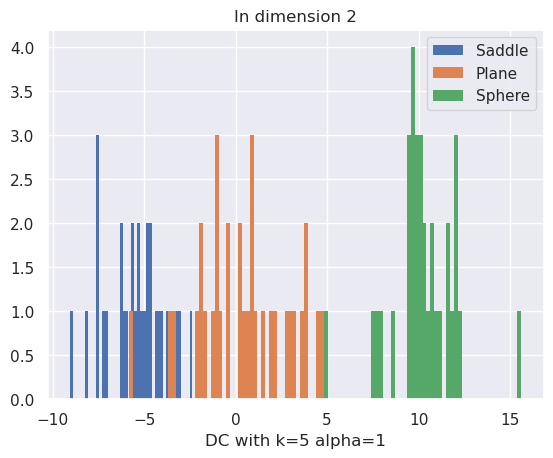

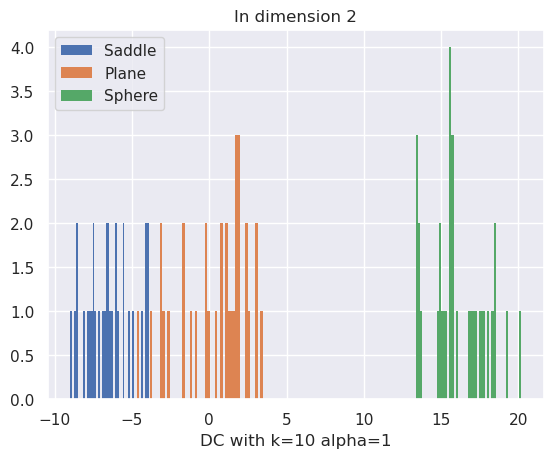

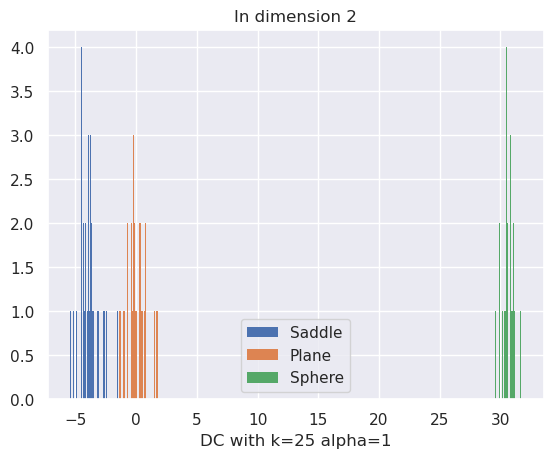

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=1,"(0.8377663883518671, 3.107262234835446e-27)",0.464663
DC with k=10 alpha=1,"(0.8298572574242141, 2.55950536163737e-26)",0.467153
DC with k=25 alpha=1,"(0.7283408003942018, 1.3077001090634165e-17)",0.464663


In [ ]:
SS.plot()
SS.table()

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, t=t, dim=dim)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [25]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|                                                                                                               | 0/99 [00:00<?, ?it/s]2024-03-08 14:15:47,727:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 14:15:48,471:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   1%|█                                                                                                      | 1/99 [00:01<02:15,  1.38s/it]2024-03-08 14:15:49,121:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 14:15:49,742:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   2%|██                                                                                                     | 2/99 [00:02<02:08,  1.33s/it]2024-03-08 14:15:50,436:[WARNING](pygsp.graphs.graph.check_weig

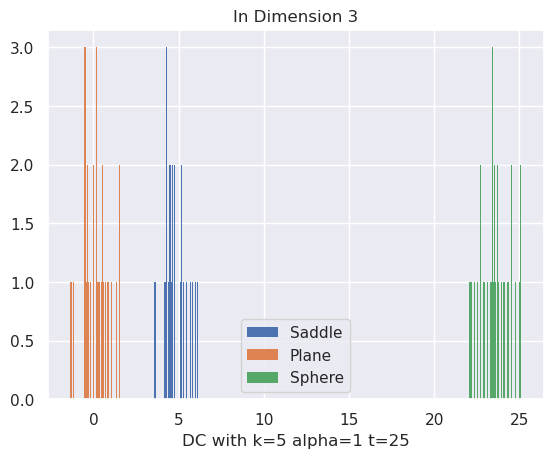

TypeError: descriptor '__weakref__' for 'SadSpheres' objects doesn't apply to a 'SadSpheres' object

In [ ]:
SS.plot(title="In Dimension 3")
SS.table()

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 18, # num pointclouds to make in total
    num_points = 8000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, t=t, dim=dim)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [25]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|                                                                                                               | 0/18 [00:00<?, ?it/s]2024-03-08 15:21:59,409:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 15:22:12,573:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   6%|█████▋                                                                                                 | 1/18 [00:27<07:39, 27.02s/it]2024-03-08 15:22:26,750:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 15:22:38,516:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:  11%|███████████▍                                                                                           | 2/18 [00:52<07:00, 26.28s/it]2024-03-08 15:22:52,100:[WARNING](pygsp.graphs.graph.check_weig

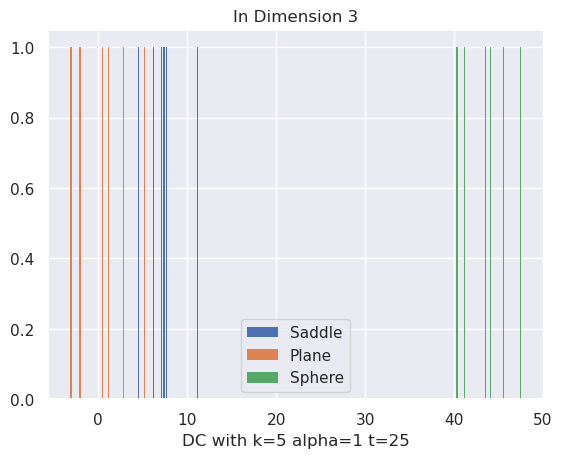

TypeError: descriptor '__weakref__' for 'SadSpheres' objects doesn't apply to a 'SadSpheres' object

In [ ]:
SS.plot(title="In Dimension 3")
SS.table()

## Dimension 4

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 99/99 [14:39<00:00,  8.88s/


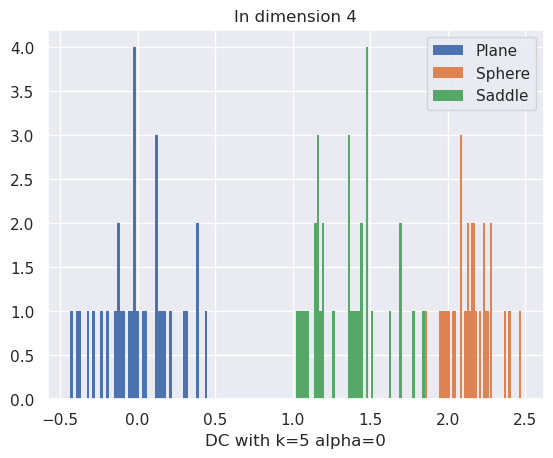

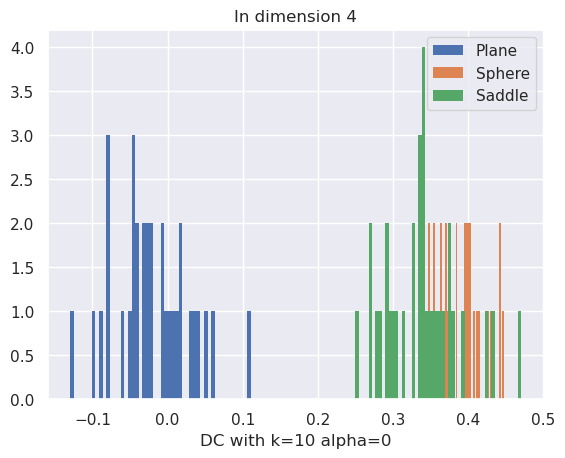

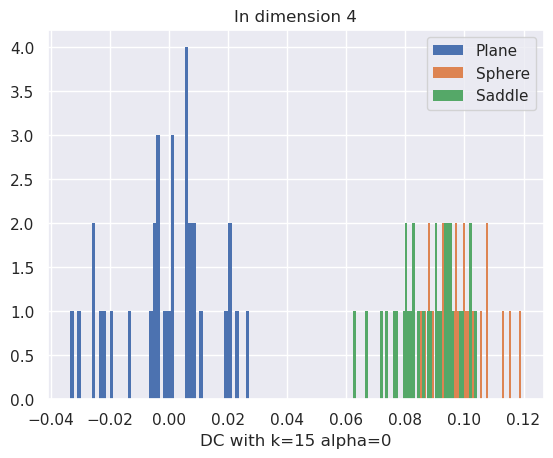

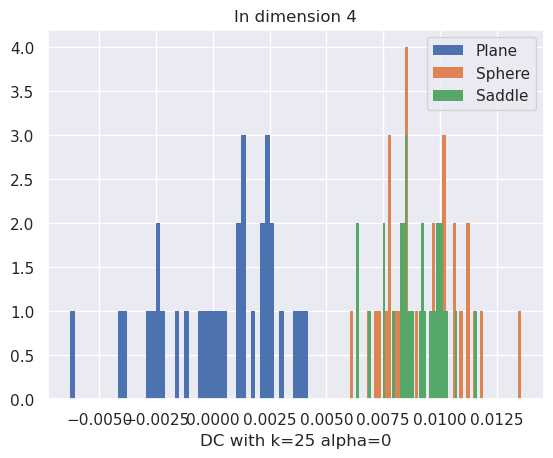

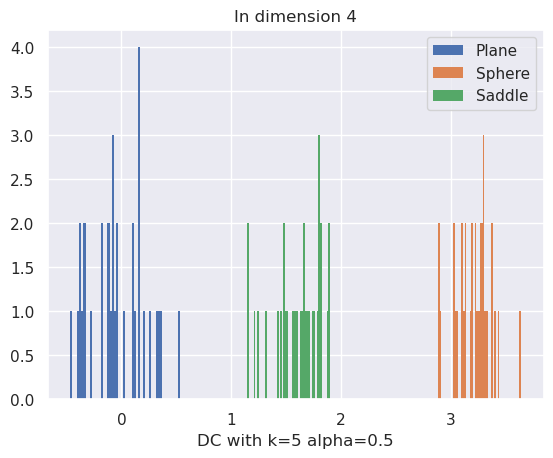

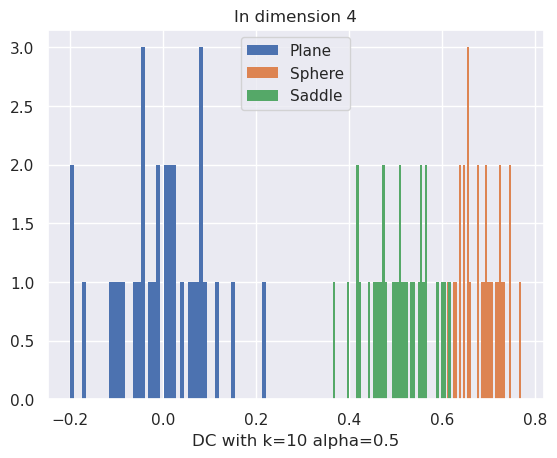

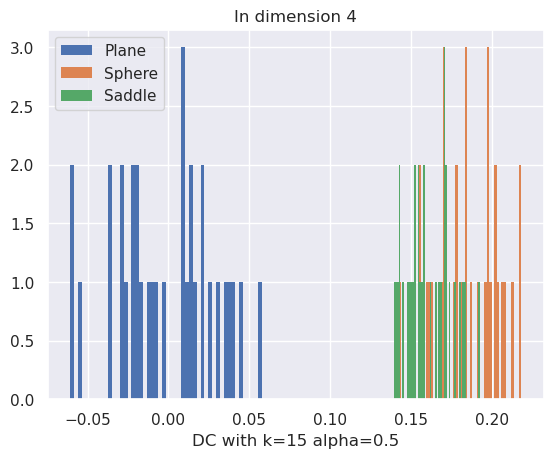

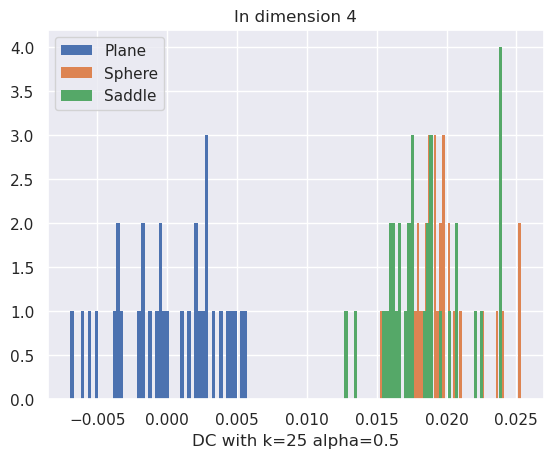

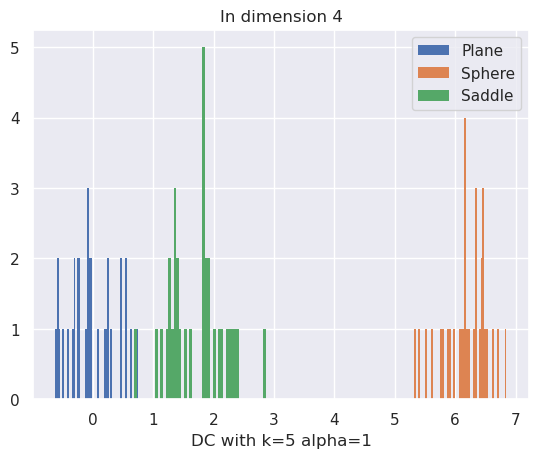

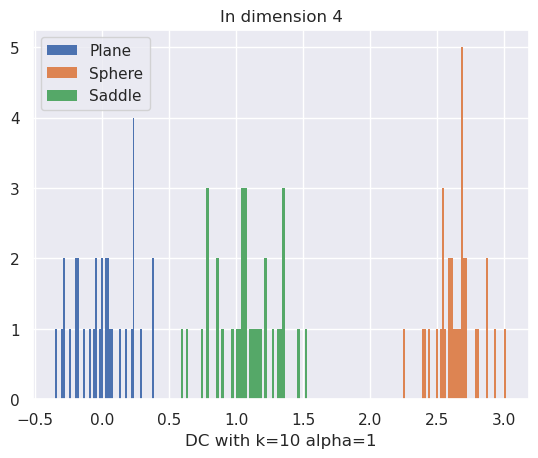

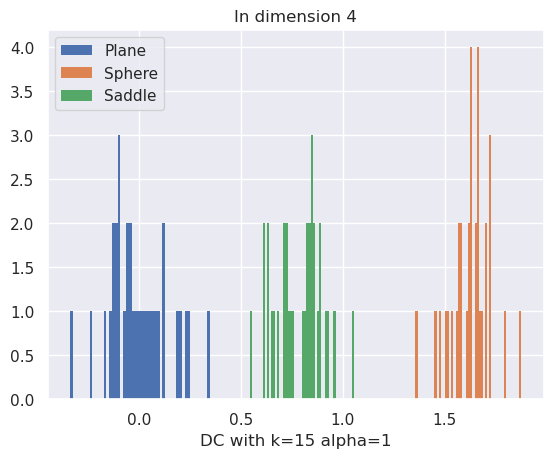

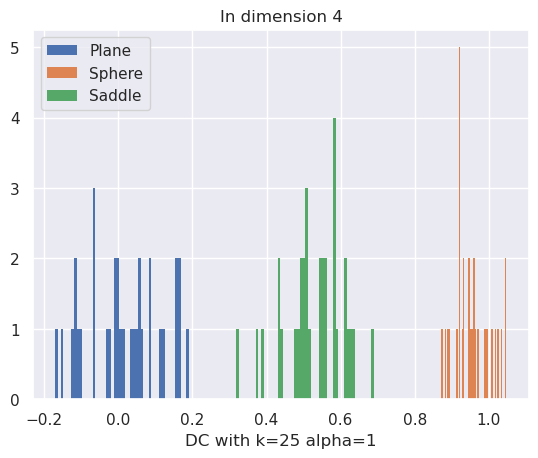

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=0,"(-0.04499011999076727, 0.6583554448582754)",0.261786
DC with k=10 alpha=0,"(-0.28908536002322605, 0.003707113948176866)",0.317535
DC with k=15 alpha=0,"(-0.30865419503597136, 0.0018814657194790557)",0.211444
DC with k=25 alpha=0,"(-0.35141322780973505, 0.00036168370688376074)",0.165383
DC with k=5 alpha=0.5,"(0.09450702089794012, 0.35212504851489146)",0.261786
DC with k=10 alpha=0.5,"(-0.17165696995125101, 0.08933638174702259)",0.211444
DC with k=15 alpha=0.5,"(-0.288984708115415, 0.0037196278447960834)",0.227703
DC with k=25 alpha=0.5,"(-0.3461616122401221, 0.00044863764091177606)",0.211444
DC with k=5 alpha=1,"(0.3372264655378036, 0.0006417995761138468)",0.298260


In [ ]:
SS.plot()
SS.table()

# Fixed Kernel with Self Loops

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_graph_former_self_loops(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    # np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, sigma):
    global SS
    graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {sigma=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for sigma in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, sigma)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [08:57<00:00,  5.43s/it]


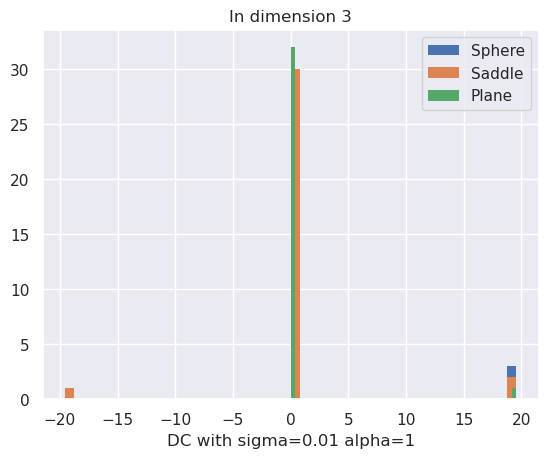

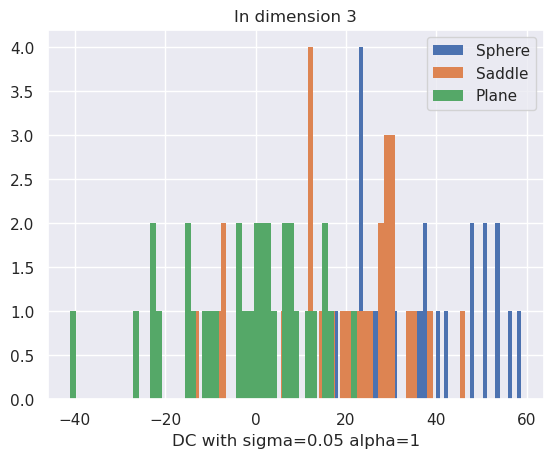

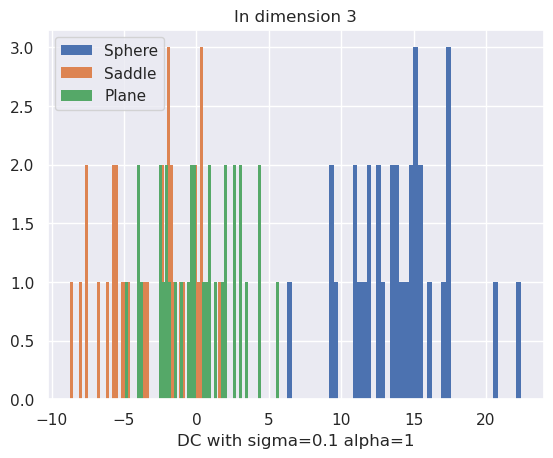

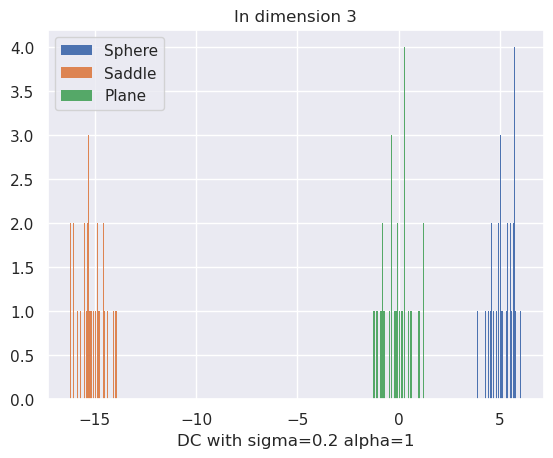

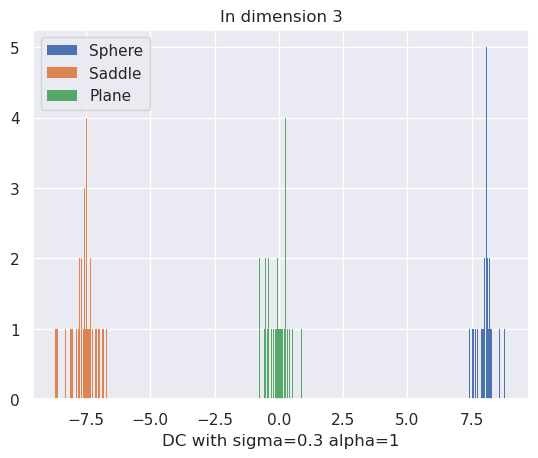

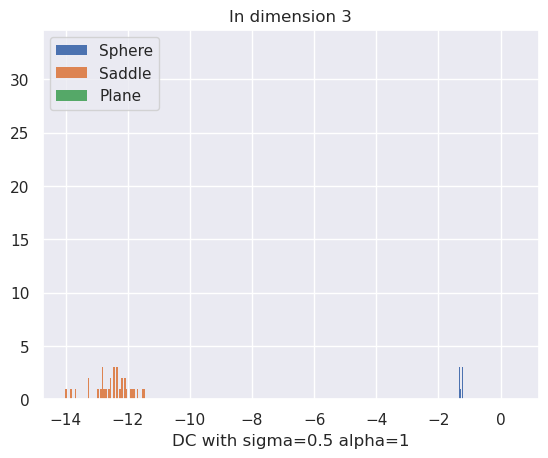

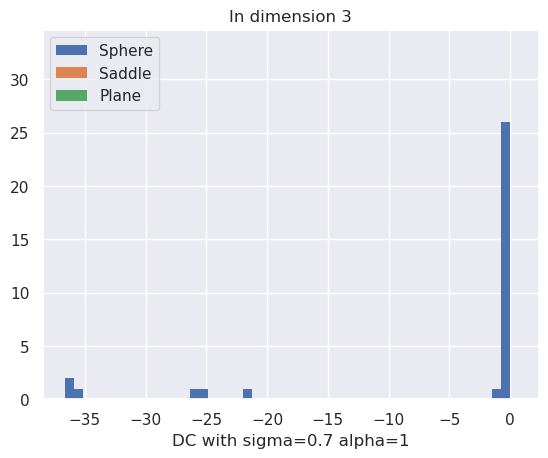

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with sigma=0.01 alpha=1,"(0.033235004702199575, 0.7439896585895746)",0.014250
DC with sigma=0.05 alpha=1,"(0.1059437287550668, 0.2966335787725885)",0.131744
DC with sigma=0.1 alpha=1,"(0.7258912372690158, 1.8928710675263436e-17)",0.298019
DC with sigma=0.2 alpha=1,"(0.995606670506727, 1.3754391058962552e-101)",0.464663
DC with sigma=0.3 alpha=1,"(0.9366036884430339, 5.71277794980332e-46)",0.462200
DC with sigma=0.5 alpha=1,"(0.957811034703306, 2.5048908781999233e-54)",0.636514
DC with sigma=0.7 alpha=1,"(-0.2324110984821006, 0.020619153453011695)",0.096119


In [ ]:
SS.plot()
SS.table()

# Conclusion